In [1]:
import pickle
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kafka import KafkaConsumer
from sklearn.metrics import f1_score
import copy
from collections import deque
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
from river import drift

In [41]:
class GraphNet(nn.Module):
    def __init__(self, in_channels, gcn_hidden, dnn_hidden, out_channels,dropout=0.1):
        super().__init__()
        # -- GNN layers --
        self.gcn1 = GCNConv(in_channels, gcn_hidden)
        self.gcn2 = GCNConv(gcn_hidden, gcn_hidden)
        
        self.dropout = nn.Dropout(p=dropout)

        # -- DNN layers --
        self.lin1 = nn.Linear(gcn_hidden, dnn_hidden)
        self.lin2 = nn.Linear(dnn_hidden, out_channels)

    def forward(self, x, edge_index):
        # ----- GNN stage -----
        x = self.gcn1(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.gcn2(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)
        x = self.dropout(x)

        # ----- DNN stage -----
        x = self.lin1(x)              # shape: [num_nodes, dnn_hidden]
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.lin2(x)              # shape: [num_nodes, out_channels]

        return F.log_softmax(x, dim=1) # for multi-class or binary classification

In [42]:
# Load scaler and get feature columns
with open('phase2_gnndnn_scaler.pkl', 'rb') as scaler_file:
    scaler = joblib.load(scaler_file)
    
feature_columns = [
    "fwd header length",
    "destination port",
    "init_win_bytes_forward",
    "bwd packet length min",
    "bwd packets/s",
    "min packet length",
    "ack flag count",
    "psh flag count",
    "flow iat min",
    "flow packets/s",
]

all_columns = scaler.feature_names_in_  # 69 columns that need to be scaled
print(f"Scaler loaded successfully with {len(all_columns)} features!")
print(f"Will select {len(feature_columns)} features from these for modeling")

Scaler loaded successfully with 69 features!
Will select 10 features from these for modeling


In [43]:
#Load data stream
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False,
    consumer_timeout_ms=5000
)

if consumer.bootstrap_connected():
    print("Successfully connected to Kafka broker")
else:
    print("Couldn't connect to bootstrap server.")

Successfully connected to Kafka broker


In [44]:
model = GraphNet(
    in_channels=len(feature_columns),  # number of features
    gcn_hidden=128,           # size of GCN hidden embeddings
    dnn_hidden=64,           # size of hidden layer in the MLP
    out_channels=2,           # final classes (0=Benign, 1=Attack)
    dropout=0.1
)
model.load_state_dict(torch.load("GNN_DNN_top10.pth", map_location=torch.device('cpu')))
model.eval()

GraphNet(
  (gcn1): GCNConv(10, 128)
  (gcn2): GCNConv(128, 128)
  (dropout): Dropout(p=0.1, inplace=False)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)

In [27]:
static_model = model
dynamic_model = copy.deepcopy(model)

In [28]:
static_scaler = StandardScaler()
dynamic_scaler = StandardScaler()
scaler_initialized = False

In [29]:
window_size = 1000
max_window_steps = 15
window_count = 0

# Store tuples of (original_unscaled_features, scaled_selected_features, label)
window_data = deque(maxlen=window_size)
replay_buffer = deque(maxlen=2000)

dynamic_model_f1 = []
static_model_f1 = []
window_indices = []

ema_alpha = 0.3
adwin_dynamic = drift.ADWIN()
adwin_static = drift.ADWIN()

<h2>Streaming using ADWIN</h2>

In [30]:
initial_samples = []

for idx, message in enumerate(consumer):
    try:
        # Parse message
        row = message.value.decode().strip().split(',')
            
        # Skip empty messages
        if not row:
            continue
            
        # Extract label and features
        try:
            label = row[-1].strip().replace('\\n"', '').replace('"', '')
            features = row[:-1]
        except IndexError:
            continue
        
        # Convert label to numeric safely
        try:
            label = int(float(label))
        except (ValueError, TypeError):
            label = 0
            
        # Create DataFrame with flexible column handling
        try:
            # Pad features to expected length (78)
            num_features = len(features)
            expected_features = 78
            features = features[:expected_features] + ['0']*(expected_features - num_features)
                
            # Create DataFrame with numbered columns
            row_df = pd.DataFrame([features], columns=[f"feature_{i}" for i in range(expected_features)])
            row_df['label'] = label
            
            # Map to our expected column names (all_columns)
            for i, col in enumerate(all_columns):
                if i < expected_features:
                    row_df[col] = row_df[f"feature_{i}"]
                else:
                    row_df[col] = 0
            
            # Convert all features to numeric
            for col in all_columns:
                row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)
                
        except Exception as e:
            continue
            
        # Store original unscaled values
        original_features = row_df[all_columns].values[0]
        
        # Initialize scalers with first window_size samples
        if not scaler_initialized:
            initial_samples.append(original_features)
            
            if len(initial_samples) >= window_size:
                static_scaler.fit(initial_samples)
                dynamic_scaler.fit(initial_samples)
                scaler_initialized = True
                print(f"\nScalers initialized with {len(initial_samples)} samples")
                initial_samples.clear()  # Free memory
            else:
                continue  # Skip processing until we have enough samples
        
        # Only proceed if scalers are initialized
        if scaler_initialized:
            # Scale all 69 features
            scaled_all = dynamic_scaler.transform([original_features])[0]
            
            # Select our 10 important features
            selected_features = pd.DataFrame([scaled_all], columns=all_columns)[feature_columns].values[0]
            
            # Store data
            window_data.append((original_features, selected_features, label))
            replay_buffer.append((original_features, selected_features, label))
            
            # Print progress
            if idx % 100 == 0:
                print(f"Processed {idx} messages (Window: {len(window_data)}/{window_size})")
            
            # Process window when full
            if len(window_data) == window_size:
                print(f"\n=== Processing window {window_count} ===")
                
                # Take copy and clear window
                current_window = list(window_data)
                window_data.clear()
                
                # Prepare data
                X_window = np.array([x[1] for x in current_window])  # Using scaled selected features
                y_window = np.array([x[2] for x in current_window])
                
                # Add replay samples
                if replay_buffer:
                    replay_samples = [replay_buffer[i] for i in 
                                    np.random.choice(len(replay_buffer), min(len(replay_buffer), window_size), 
                                    replace=False)]
                    X_window = np.vstack([X_window, [x[1] for x in replay_samples]])
                    y_window = np.concatenate([y_window, [x[2] for x in replay_samples]])
                
                # Build graph
                k = 5
                knn_graph = kneighbors_graph(X_window, n_neighbors=k, include_self=False)
                edge_index = torch.tensor(knn_graph.nonzero(), dtype=torch.long)
                
                # Convert to tensors
                X_tensor = torch.tensor(X_window, dtype=torch.float32)
                y_tensor = torch.tensor(y_window, dtype=torch.long)
                
                # Evaluate models
                with torch.no_grad():
                    dynamic_preds = dynamic_model(X_tensor, edge_index).argmax(dim=1).numpy()
                    static_preds = static_model(X_tensor, edge_index).argmax(dim=1).numpy()
                
                dynamic_f1 = f1_score(y_window, dynamic_preds, average='weighted', zero_division=0)
                static_f1 = f1_score(y_window, static_preds, average='weighted', zero_division=0)
                
                print(f"Dynamic F1: {dynamic_f1:.3f} | Static F1: {static_f1:.3f}")
                print(f"Class distribution: {pd.Series(y_window).value_counts().to_dict()}")
                
                # Store metrics
                dynamic_model_f1.append(dynamic_f1)
                static_model_f1.append(static_f1)
                window_indices.append(window_count)
                
                # Update both ADWIN detectors with window-level correctness
                dynamic_correctness = 1 if dynamic_f1 > 0.5 else 0
                static_correctness = 1 if static_f1 > 0.5 else 0
                adwin_dynamic.update(dynamic_correctness)
                adwin_static.update(static_correctness)
                
                # Retrain if needed
                if adwin_dynamic.drift_detected:
                    print(f"\nRetraining dynamic model...")
                    
                    # Get original features for retraining
                    X_original = np.array([x[0] for x in current_window])
                    
                    # Update scaler with EMA
                    new_scaler = StandardScaler()
                    new_scaler.fit(X_original)
                    dynamic_scaler.mean_ = (1-ema_alpha)*dynamic_scaler.mean_ + ema_alpha*new_scaler.mean_
                    dynamic_scaler.scale_ = (1-ema_alpha)*dynamic_scaler.scale_ + ema_alpha*new_scaler.scale_
                    
                    # Train model
                    dynamic_model.train()
                    optimizer = optim.Adam(dynamic_model.parameters(), lr=0.001)
                    
                    for epoch in range(50):
                        optimizer.zero_grad()
                        outputs = dynamic_model(X_tensor, edge_index)
                        loss = F.cross_entropy(outputs, y_tensor)
                        loss.backward()
                        optimizer.step()
                        if epoch % 10 == 0:
                            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
                    
                    dynamic_model.eval()
                    adwin_dynamic.reset()
                    print("Retraining complete")
                    
                if adwin_static.drift_detected:
                    print(f"Warning: Static model drift detected (F1: {static_f1:.3f})")
                
                window_count += 1
                if window_count >= max_window_steps:
                    print("\nReached maximum window steps")
                    break
                    
    except Exception as e:
        print(f"Error on message {idx}: {str(e)}")
        continue

print("\nProcessing complete")
print(f"Processed {window_count} windows")
print(f"Final window size: {len(window_data)}")


Scalers initialized with 1000 samples
Processed 1000 messages (Window: 2/1000)
Processed 1100 messages (Window: 102/1000)
Processed 1200 messages (Window: 202/1000)
Processed 1300 messages (Window: 302/1000)
Processed 1400 messages (Window: 402/1000)
Processed 1500 messages (Window: 502/1000)
Processed 1600 messages (Window: 602/1000)
Processed 1700 messages (Window: 702/1000)
Processed 1800 messages (Window: 802/1000)
Processed 1900 messages (Window: 902/1000)

=== Processing window 0 ===
Dynamic F1: 0.686 | Static F1: 0.686
Class distribution: {0: 1588, 1: 412}
Processed 2000 messages (Window: 2/1000)
Processed 2100 messages (Window: 102/1000)
Processed 2200 messages (Window: 202/1000)
Processed 2300 messages (Window: 302/1000)
Processed 2400 messages (Window: 402/1000)
Processed 2500 messages (Window: 502/1000)
Processed 2600 messages (Window: 602/1000)
Processed 2700 messages (Window: 702/1000)
Processed 2800 messages (Window: 802/1000)
Processed 2900 messages (Window: 902/1000)



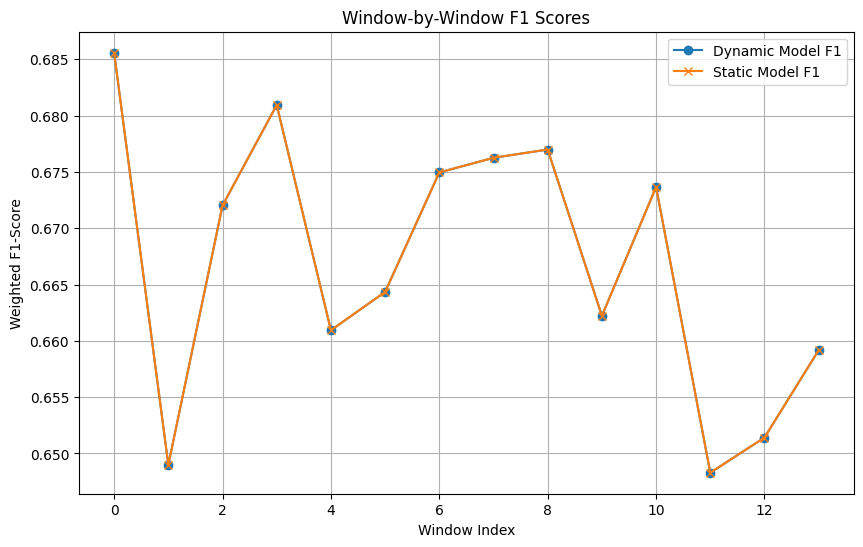

In [31]:
import matplotlib.pyplot as plt

# Plotting F1 scores per window
plt.figure(figsize=(10, 6))
plt.plot(window_indices, dynamic_model_f1, label='Dynamic Model F1', marker='o')
plt.plot(window_indices, static_model_f1, label='Static Model F1', marker='x')
plt.xlabel('Window Index')
plt.ylabel('Weighted F1-Score')
plt.title('Window-by-Window F1 Scores')
plt.legend()
plt.grid(True)
plt.show()


<h2>Streaming using PageHinkley</h2>

In [36]:
static_model = model
dynamic_model = copy.deepcopy(model)

In [37]:
static_scaler = StandardScaler()
dynamic_scaler = StandardScaler()
scaler_initialized = False

In [38]:
window_size = 1000
max_window_steps = 15
window_count = 0

# Store tuples of (original_unscaled_features, scaled_selected_features, label)
window_data = deque(maxlen=window_size)
replay_buffer = deque(maxlen=2000)

dynamic_model_f1 = []
static_model_f1 = []
window_indices = []

ema_alpha = 0.3
ph_dynamic = drift.PageHinkley()
ph_static = drift.PageHinkley()

In [39]:
initial_samples = []

for idx, message in enumerate(consumer):
    try:
        # Parse message
        row = message.value.decode().strip().split(',')
            
        # Skip empty messages
        if not row:
            continue
            
        # Extract label and features
        try:
            label = row[-1].strip().replace('\\n"', '').replace('"', '')
            features = row[:-1]
        except IndexError:
            continue
        
        # Convert label to numeric safely
        try:
            label = int(float(label))
        except (ValueError, TypeError):
            label = 0
            
        # Create DataFrame with flexible column handling
        try:
            # Pad features to expected length (78)
            num_features = len(features)
            expected_features = 78
            features = features[:expected_features] + ['0']*(expected_features - num_features)
                
            # Create DataFrame with numbered columns
            row_df = pd.DataFrame([features], columns=[f"feature_{i}" for i in range(expected_features)])
            row_df['label'] = label
            
            # Map to our expected column names (all_columns)
            for i, col in enumerate(all_columns):
                if i < expected_features:
                    row_df[col] = row_df[f"feature_{i}"]
                else:
                    row_df[col] = 0
            
            # Convert all features to numeric
            for col in all_columns:
                row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)
                
        except Exception as e:
            continue
            
        # Store original unscaled values
        original_features = row_df[all_columns].values[0]
        
        # Initialize scalers with first window_size samples
        if not scaler_initialized:
            initial_samples.append(original_features)
            
            if len(initial_samples) >= window_size:
                static_scaler.fit(initial_samples)
                dynamic_scaler.fit(initial_samples)
                scaler_initialized = True
                print(f"\nScalers initialized with {len(initial_samples)} samples")
                initial_samples.clear()  # Free memory
            else:
                continue  # Skip processing until we have enough samples
        
        # Only proceed if scalers are initialized
        if scaler_initialized:
            # Scale all 69 features
            scaled_all = dynamic_scaler.transform([original_features])[0]
            
            # Select our 10 important features
            selected_features = pd.DataFrame([scaled_all], columns=all_columns)[feature_columns].values[0]
            
            # Store data
            window_data.append((original_features, selected_features, label))
            replay_buffer.append((original_features, selected_features, label))
            
            # Print progress
            if idx % 100 == 0:
                print(f"Processed {idx} messages (Window: {len(window_data)}/{window_size})")
            
            # Process window when full
            if len(window_data) == window_size:
                print(f"\n=== Processing window {window_count} ===")
                
                # Take copy and clear window
                current_window = list(window_data)
                window_data.clear()
                
                # Prepare data
                X_window = np.array([x[1] for x in current_window])  # Using scaled selected features
                y_window = np.array([x[2] for x in current_window])
                
                # Add replay samples
                if replay_buffer:
                    replay_samples = [replay_buffer[i] for i in 
                                    np.random.choice(len(replay_buffer), min(len(replay_buffer), window_size), 
                                    replace=False)]
                    X_window = np.vstack([X_window, [x[1] for x in replay_samples]])
                    y_window = np.concatenate([y_window, [x[2] for x in replay_samples]])
                
                # Build graph
                k = 5
                knn_graph = kneighbors_graph(X_window, n_neighbors=k, include_self=False)
                edge_index = torch.tensor(knn_graph.nonzero(), dtype=torch.long)
                
                # Convert to tensors
                X_tensor = torch.tensor(X_window, dtype=torch.float32)
                y_tensor = torch.tensor(y_window, dtype=torch.long)
                
                # Evaluate models
                with torch.no_grad():
                    dynamic_preds = dynamic_model(X_tensor, edge_index).argmax(dim=1).numpy()
                    static_preds = static_model(X_tensor, edge_index).argmax(dim=1).numpy()
                
                dynamic_f1 = f1_score(y_window, dynamic_preds, average='weighted', zero_division=0)
                static_f1 = f1_score(y_window, static_preds, average='weighted', zero_division=0)
                
                print(f"Dynamic F1: {dynamic_f1:.3f} | Static F1: {static_f1:.3f}")
                print(f"Class distribution: {pd.Series(y_window).value_counts().to_dict()}")
                
                # Store metrics
                dynamic_model_f1.append(dynamic_f1)
                static_model_f1.append(static_f1)
                window_indices.append(window_count)
                
                # Update both ADWIN detectors with window-level correctness
                dynamic_correctness = 1 if dynamic_f1 > 0.5 else 0
                static_correctness = 1 if static_f1 > 0.5 else 0
                ph_dynamic.update(dynamic_correctness)
                ph_static.update(static_correctness)
                
                # Retrain if needed
                if ph_dynamic.drift_detected:
                    print(f"\nRetraining dynamic model...")
                    
                    # Get original features for retraining
                    X_original = np.array([x[0] for x in current_window])
                    
                    # Update scaler with EMA
                    new_scaler = StandardScaler()
                    new_scaler.fit(X_original)
                    dynamic_scaler.mean_ = (1-ema_alpha)*dynamic_scaler.mean_ + ema_alpha*new_scaler.mean_
                    dynamic_scaler.scale_ = (1-ema_alpha)*dynamic_scaler.scale_ + ema_alpha*new_scaler.scale_
                    
                    # Train model
                    dynamic_model.train()
                    optimizer = optim.Adam(dynamic_model.parameters(), lr=0.001)
                    
                    for epoch in range(50):
                        optimizer.zero_grad()
                        outputs = dynamic_model(X_tensor, edge_index)
                        loss = F.cross_entropy(outputs, y_tensor)
                        loss.backward()
                        optimizer.step()
                        if epoch % 10 == 0:
                            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
                    
                    dynamic_model.eval()
                    ph_dynamic.reset()
                    print("Retraining complete")
                    
                if ph_static.drift_detected:
                    print(f"Warning: Static model drift detected (F1: {static_f1:.3f})")
                
                window_count += 1
                if window_count >= max_window_steps:
                    print("\nReached maximum window steps")
                    break
                    
    except Exception as e:
        print(f"Error on message {idx}: {str(e)}")
        continue

print("\nProcessing complete")
print(f"Processed {window_count} windows")
print(f"Final window size: {len(window_data)}")


Scalers initialized with 1000 samples
Processed 1000 messages (Window: 2/1000)
Processed 1100 messages (Window: 102/1000)
Processed 1200 messages (Window: 202/1000)
Processed 1300 messages (Window: 302/1000)
Processed 1400 messages (Window: 402/1000)
Processed 1500 messages (Window: 502/1000)
Processed 1600 messages (Window: 602/1000)
Processed 1700 messages (Window: 702/1000)
Processed 1800 messages (Window: 802/1000)
Processed 1900 messages (Window: 902/1000)

=== Processing window 0 ===
Dynamic F1: 0.648 | Static F1: 0.648
Class distribution: {0: 1596, 1: 404}
Processed 2000 messages (Window: 2/1000)
Processed 2100 messages (Window: 102/1000)
Processed 2200 messages (Window: 202/1000)
Processed 2300 messages (Window: 302/1000)
Processed 2400 messages (Window: 402/1000)
Processed 2500 messages (Window: 502/1000)
Processed 2600 messages (Window: 602/1000)
Processed 2700 messages (Window: 702/1000)
Processed 2800 messages (Window: 802/1000)
Processed 2900 messages (Window: 902/1000)



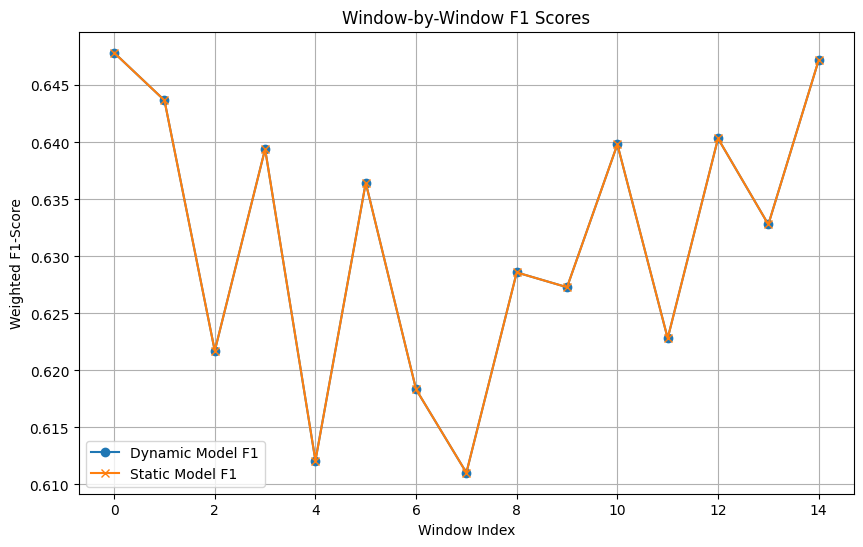

In [40]:
import matplotlib.pyplot as plt

# Plotting F1 scores per window
plt.figure(figsize=(10, 6))
plt.plot(window_indices, dynamic_model_f1, label='Dynamic Model F1', marker='o')
plt.plot(window_indices, static_model_f1, label='Static Model F1', marker='x')
plt.xlabel('Window Index')
plt.ylabel('Weighted F1-Score')
plt.title('Window-by-Window F1 Scores')
plt.legend()
plt.grid(True)
plt.show()


<h2> Streaming using KSWIN</h2>

In [45]:
static_model = model
dynamic_model = copy.deepcopy(model)

In [46]:
static_scaler = StandardScaler()
dynamic_scaler = StandardScaler()
scaler_initialized = False

In [47]:
window_size = 1000
max_window_steps = 15
window_count = 0

# Store tuples of (original_unscaled_features, scaled_selected_features, label)
window_data = deque(maxlen=window_size)
replay_buffer = deque(maxlen=2000)

dynamic_model_f1 = []
static_model_f1 = []
window_indices = []

ema_alpha = 0.3
kswin_dynamic = drift.KSWIN(seed=2021)
kswin_static = drift.KSWIN(seed=2021)

In [48]:
initial_samples = []

for idx, message in enumerate(consumer):
    try:
        # Parse message
        row = message.value.decode().strip().split(',')
            
        # Skip empty messages
        if not row:
            continue
            
        # Extract label and features
        try:
            label = row[-1].strip().replace('\\n"', '').replace('"', '')
            features = row[:-1]
        except IndexError:
            continue
        
        # Convert label to numeric safely
        try:
            label = int(float(label))
        except (ValueError, TypeError):
            label = 0
            
        # Create DataFrame with flexible column handling
        try:
            # Pad features to expected length (78)
            num_features = len(features)
            expected_features = 78
            features = features[:expected_features] + ['0']*(expected_features - num_features)
                
            # Create DataFrame with numbered columns
            row_df = pd.DataFrame([features], columns=[f"feature_{i}" for i in range(expected_features)])
            row_df['label'] = label
            
            # Map to our expected column names (all_columns)
            for i, col in enumerate(all_columns):
                if i < expected_features:
                    row_df[col] = row_df[f"feature_{i}"]
                else:
                    row_df[col] = 0
            
            # Convert all features to numeric
            for col in all_columns:
                row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)
                
        except Exception as e:
            continue
            
        # Store original unscaled values
        original_features = row_df[all_columns].values[0]
        
        # Initialize scalers with first window_size samples
        if not scaler_initialized:
            initial_samples.append(original_features)
            
            if len(initial_samples) >= window_size:
                static_scaler.fit(initial_samples)
                dynamic_scaler.fit(initial_samples)
                scaler_initialized = True
                print(f"\nScalers initialized with {len(initial_samples)} samples")
                initial_samples.clear()  # Free memory
            else:
                continue  # Skip processing until we have enough samples
        
        # Only proceed if scalers are initialized
        if scaler_initialized:
            # Scale all 69 features
            scaled_all = dynamic_scaler.transform([original_features])[0]
            
            # Select our 10 important features
            selected_features = pd.DataFrame([scaled_all], columns=all_columns)[feature_columns].values[0]
            
            # Store data
            window_data.append((original_features, selected_features, label))
            replay_buffer.append((original_features, selected_features, label))
            
            # Print progress
            if idx % 100 == 0:
                print(f"Processed {idx} messages (Window: {len(window_data)}/{window_size})")
            
            # Process window when full
            if len(window_data) == window_size:
                print(f"\n=== Processing window {window_count} ===")
                
                # Take copy and clear window
                current_window = list(window_data)
                window_data.clear()
                
                # Prepare data
                X_window = np.array([x[1] for x in current_window])  # Using scaled selected features
                y_window = np.array([x[2] for x in current_window])
                
                # Add replay samples
                if replay_buffer:
                    replay_samples = [replay_buffer[i] for i in 
                                    np.random.choice(len(replay_buffer), min(len(replay_buffer), window_size), 
                                    replace=False)]
                    X_window = np.vstack([X_window, [x[1] for x in replay_samples]])
                    y_window = np.concatenate([y_window, [x[2] for x in replay_samples]])
                
                # Build graph
                k = 5
                knn_graph = kneighbors_graph(X_window, n_neighbors=k, include_self=False)
                edge_index = torch.tensor(knn_graph.nonzero(), dtype=torch.long)
                
                # Convert to tensors
                X_tensor = torch.tensor(X_window, dtype=torch.float32)
                y_tensor = torch.tensor(y_window, dtype=torch.long)
                
                # Evaluate models
                with torch.no_grad():
                    dynamic_preds = dynamic_model(X_tensor, edge_index).argmax(dim=1).numpy()
                    static_preds = static_model(X_tensor, edge_index).argmax(dim=1).numpy()
                
                dynamic_f1 = f1_score(y_window, dynamic_preds, average='weighted', zero_division=0)
                static_f1 = f1_score(y_window, static_preds, average='weighted', zero_division=0)
                
                print(f"Dynamic F1: {dynamic_f1:.3f} | Static F1: {static_f1:.3f}")
                print(f"Class distribution: {pd.Series(y_window).value_counts().to_dict()}")
                
                # Store metrics
                dynamic_model_f1.append(dynamic_f1)
                static_model_f1.append(static_f1)
                window_indices.append(window_count)
                
                # Update both ADWIN detectors with window-level correctness
                dynamic_correctness = 1 if dynamic_f1 > 0.5 else 0
                static_correctness = 1 if static_f1 > 0.5 else 0
                kswin_dynamic.update(dynamic_correctness)
                kswin_static.update(static_correctness)
                
                # Retrain if needed
                if kswin_dynamic.drift_detected:
                    print(f"\nRetraining dynamic model...")
                    
                    # Get original features for retraining
                    X_original = np.array([x[0] for x in current_window])
                    
                    # Update scaler with EMA
                    new_scaler = StandardScaler()
                    new_scaler.fit(X_original)
                    dynamic_scaler.mean_ = (1-ema_alpha)*dynamic_scaler.mean_ + ema_alpha*new_scaler.mean_
                    dynamic_scaler.scale_ = (1-ema_alpha)*dynamic_scaler.scale_ + ema_alpha*new_scaler.scale_
                    
                    # Train model
                    dynamic_model.train()
                    optimizer = optim.Adam(dynamic_model.parameters(), lr=0.001)
                    
                    for epoch in range(50):
                        optimizer.zero_grad()
                        outputs = dynamic_model(X_tensor, edge_index)
                        loss = F.cross_entropy(outputs, y_tensor)
                        loss.backward()
                        optimizer.step()
                        if epoch % 10 == 0:
                            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
                    
                    dynamic_model.eval()
                    kswin_dynamic.reset()
                    print("Retraining complete")
                    
                if kswin_static.drift_detected:
                    print(f"Warning: Static model drift detected (F1: {static_f1:.3f})")
                
                window_count += 1
                if window_count >= max_window_steps:
                    print("\nReached maximum window steps")
                    break
                    
    except Exception as e:
        print(f"Error on message {idx}: {str(e)}")
        continue

print("\nProcessing complete")
print(f"Processed {window_count} windows")
print(f"Final window size: {len(window_data)}")


Scalers initialized with 1000 samples
Processed 1000 messages (Window: 2/1000)
Processed 1100 messages (Window: 102/1000)
Processed 1200 messages (Window: 202/1000)
Processed 1300 messages (Window: 302/1000)
Processed 1400 messages (Window: 402/1000)
Processed 1500 messages (Window: 502/1000)
Processed 1600 messages (Window: 602/1000)
Processed 1700 messages (Window: 702/1000)
Processed 1800 messages (Window: 802/1000)
Processed 1900 messages (Window: 902/1000)

=== Processing window 0 ===
Dynamic F1: 0.648 | Static F1: 0.648
Class distribution: {0: 1596, 1: 404}
Processed 2000 messages (Window: 2/1000)
Processed 2100 messages (Window: 102/1000)
Processed 2200 messages (Window: 202/1000)
Processed 2300 messages (Window: 302/1000)
Processed 2400 messages (Window: 402/1000)
Processed 2500 messages (Window: 502/1000)
Processed 2600 messages (Window: 602/1000)
Processed 2700 messages (Window: 702/1000)
Processed 2800 messages (Window: 802/1000)
Processed 2900 messages (Window: 902/1000)



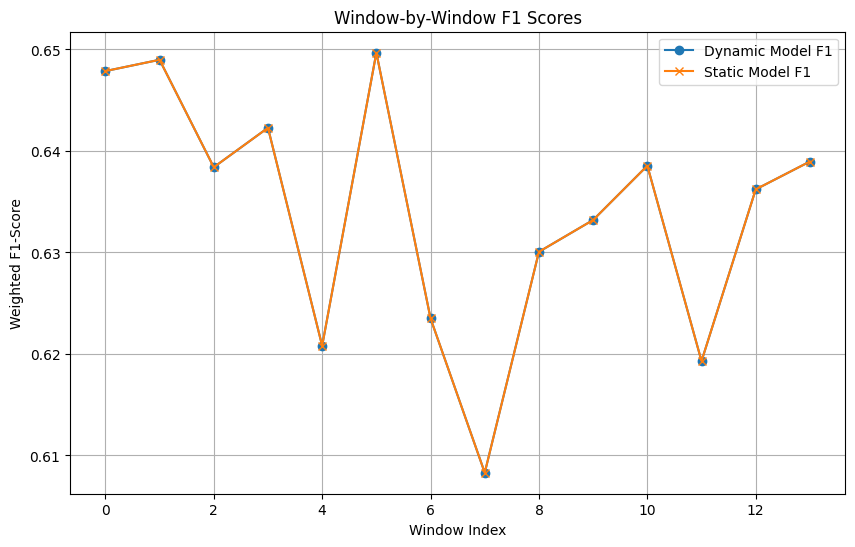

In [49]:
import matplotlib.pyplot as plt

# Plotting F1 scores per window
plt.figure(figsize=(10, 6))
plt.plot(window_indices, dynamic_model_f1, label='Dynamic Model F1', marker='o')
plt.plot(window_indices, static_model_f1, label='Static Model F1', marker='x')
plt.xlabel('Window Index')
plt.ylabel('Weighted F1-Score')
plt.title('Window-by-Window F1 Scores')
plt.legend()
plt.grid(True)
plt.show()